# Прогнозирование оттока клиентов

Распространённая проблема сети фитнес-центров - это отток клиентов. Как понять, что клиент больше не с вами? Можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.
Для любого продукта важно удержать клиента, а значит необходимо предсказать, что клиент может потерять интерес.

**Цель проекта** - обучение модели прогнозирования оттока клиентов и подготовка плана действий по удержанию клиентов.

**Задачи**:

- Провести исследовательский анализ;


- Определить признаки для обучение моделей прогнозирования и кластеризации;


- Проанализировать характерное поведение пользователей с учетом их кластера;


- Подготовить рекомендации по удержанию клиентов.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set(palette = 'muted')

In [3]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')

gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
gym_churn['Contract_period'].value_counts()

1     2207
12     960
6      833
Name: Contract_period, dtype: int64

**Описание данных**:

- `gender` — пол;


- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;


- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);


- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);


- `Phone` — наличие контактного телефона;


- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);


- `Group_visits` — факт посещения групповых занятий;


- `Age` — возраст;


- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон;


- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);


- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);


- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;


- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;


- `Churn` — факт оттока в текущем месяце.


Посмотрим `соответствие типов данных` и определим, есть ли в датафрейме `пропуски`.

In [5]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


`Типы данных подходящие, пропуски отсутствуют.`

## Исследовательский анализ данных (EDA)

- изучим средние значения и стандартные отклонения;


- Посмотрим на средние значения признаков в двух группах - тех, кто ушел в отток и тех, кто остался;


- Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);


- Построим матрицу корреляций признаков.

Проверим, есть ли в таблице дубликаты.

In [6]:
gym_churn.duplicated().sum()

0

### Средние значения признаков.

In [7]:
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


У переменных довольно `разные по величине стандартные отклонения`. Это говорит о том, что их возможно нужно стандартизировать перед обучением.

- Средняя `длительность текущего действующего абонемента` (Contract_period) составляет `4 - 5 месяцев` (4.68125).

Выделяется максимальный показатель в 12 месяцев;

- Средний `возраст клиентов` фитнес-клуба (Age) - `29 лет`.

Максимальный возрас в базе - 41 год;

- Средняя `суммарная выручка от других услуг` фитнес-центра (Avg_additional_charges_total) - `146.94`.

Максимальный показатель - 552.59;

- Средний `срок до окончания текущего действующего абонемента` (Month_to_end_contract) - `4 месяца` (4.32275).

Максимальный показатель - 12 месяцев;

- Среднее `время с момента первого обращения` в фитнес-центр (Lifetime) - `3 - 4 месяца` (3.724750).

Самое большое время удержания составляет 31 месяцев;

- Средняя `частота посещений в неделю за все время с начала действия абонемента` (Avg_class_frequency_total) `1-2 раза` в неделю (1.87902).

Максимальная частота посещений составляет 6 раз;

- Средняя `частота посещений в неделю за предыдущий месяц` (Avg_class_frequency_current_month) также `1-2 раза` в неделю (1.767052).

Максимальная частота посещений составляет 6 раз.


Про `бинарные признаки` можно сказать, что:

- `пол` клиентов представлен в соотношении `почти 50/50` (gender) (среднее - 0.51);


- большая часть клиентов `работает или проживает в районе`, где находится фитнес-клуб (Near_Location - 0.84);


- почти половина клиентов `является сотрудниками компании-парнёра` (Partner - 0.48);


- меньше `1/3 клиентов` пришли в рамках `акции "приведи друга"` (Promo_friends - 0.31);


- почти все клиенты `оставляли номер телефона` для связи (Phone - 0.9);


- `40% клиентов посещали групповые занятия` (Group_visits - 0.41).

**Сгруппируем таблицу по признаку оттока - 'Churn'** (ушел клиент или остался).

Еще раз посмотрим средние показатели.

In [8]:
gym_churn.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


`Средняя длительность текущего действующего абонемента` (Contract_period) у тех, кто:

- остался - 5-6 месяцев (5.747193);

- ушел - 1-2 месяца (1.728558).



`Средний возраст клиентов фитнес-клуба` (Age) у тех, кто:

- остался - 29 - 30 лет (29.976523);

- ушел - 26 - 27 лет (26.989632).



`Средняя суммарная выручка от других услуг` фитнес-центра (Avg_additional_charges_total) у тех, кто:

- остался - 158.44 (158.445715);

- ушел - 115.08 (115.082899).


`Средний срок до окончания текущего действующего абонемента` (Month_to_end_contract) у тех, кто:

- остался - 5 месяцев (5.283089);

- ушел - 1-2 месяца (1.662582).


`Среднее время с момента первого обращения` в фитнес-центр (Lifetime) у тех, кто:

- остался - 4 месяца (4.711807);

- ушел - до 1 месяца (0.990575).


`Средняя частота посещений в неделю за все время` с начала действия абонемента (Avg_class_frequency_total) у тех, кто:

- остался - 2 раза в неделю (2.024876);

- ушел - 1 раз в неделю (1.474995).


`Средняя частота посещений в неделю за предыдущий месяц` (Avg_class_frequency_current_month) у тех, кто:

- остался - 2 раза в неделю (2.027882);

- ушел - 1 раз в неделю (1.044546).


### Гистограммы  распределения признаков.

Посмотрим, как распределяются значения признаков для тех клиентов, кто ушёл (отток) и тех, кто остался (не попали в отток).

Разделим клиентов по признаку оттока на тех, кто ушел (`gym_lost`) и остался (`gym_not_lost`).

In [9]:
gym_lost = gym_churn[gym_churn['Churn'] == 1]

gym_not_lost = gym_churn[gym_churn['Churn'] != 1]

Построим `гистограммы распределения признаков` по группам.

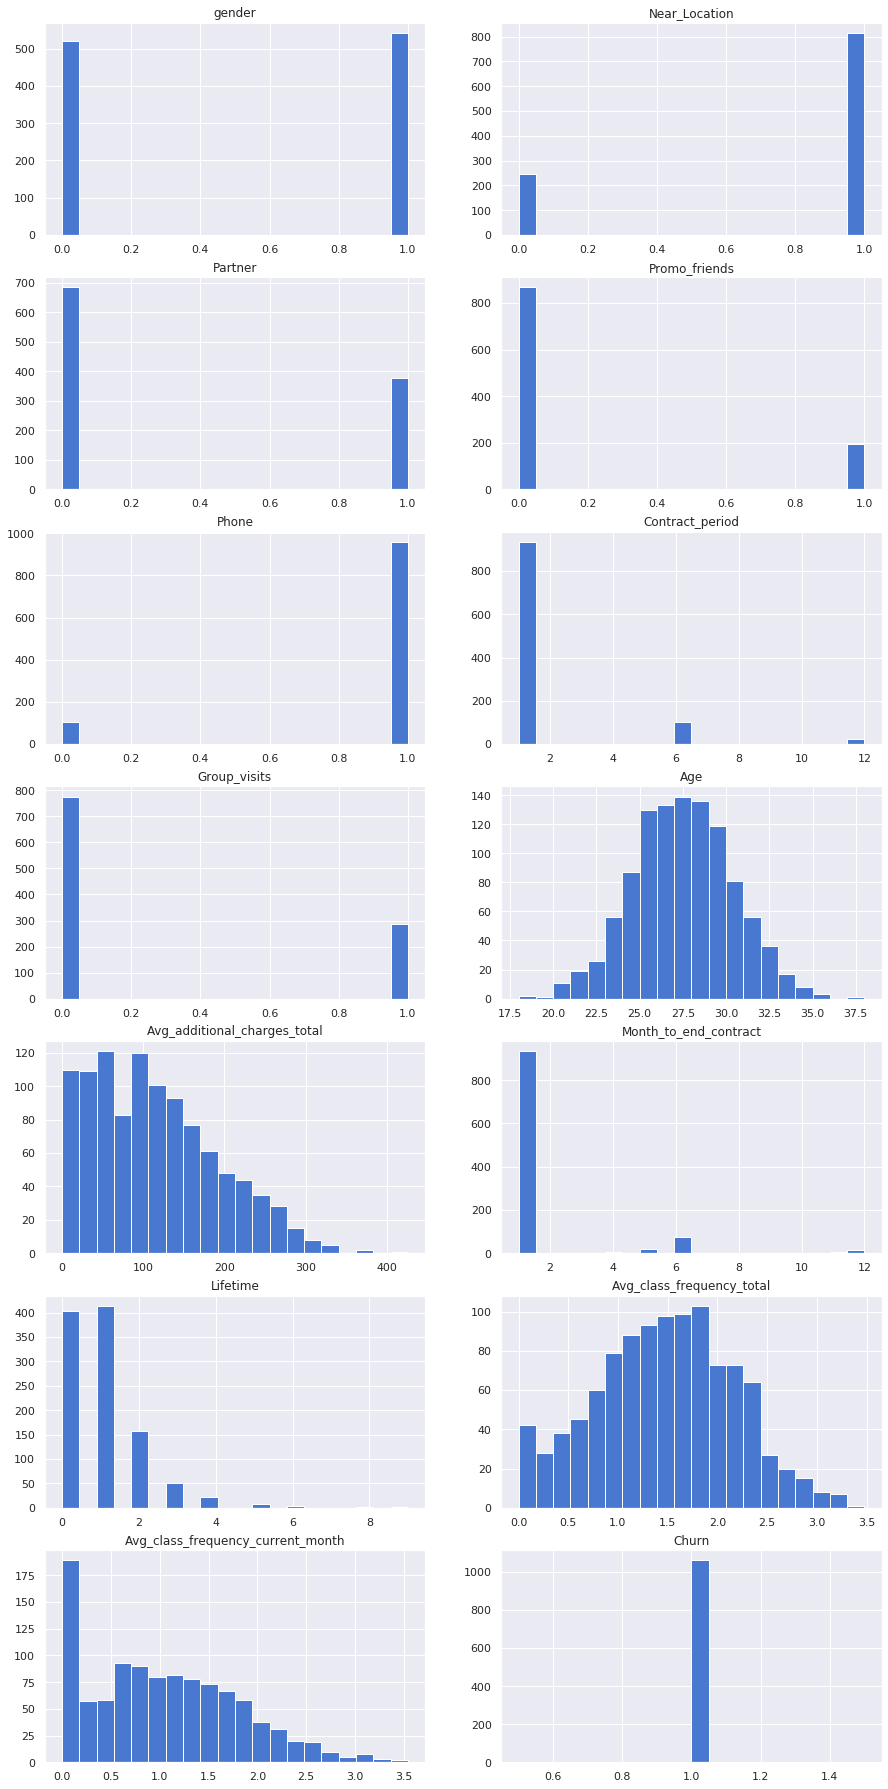

In [10]:
#для тех, кто ушел

fig, axs = plt.subplots(7, 2, figsize = (15,32))
a = 0
b = 0
for name in gym_lost.columns:
    axs[a, b].hist(gym_lost[name], bins = 20)
    axs[a, b].set_title(name)
    if b == 0:
        b = 1
    else:
        a += 1
        b = 0

Для тех, кто **ушел в отток** чаще характерно:

- проживание или работа в районе, где находится фитнес-центр (Near_Location);


- не являлись сотрудником компании-партнёра клуба (Partner);


- отсутствие факта первоначальной записи в рамках акции «приведи друга» (Promo_friends);


- оставляли номер телефона (Phone);


- длительность текущего действующего абонемента (Contract_period) - `1 месяц`;


- отсутствие факта посещения групповых занятий (Group_visits);


- средний возрас (Age) - `26-29 лет`;


- принесли среднюю суммарную выручку от других услуг фитнес-центра (Avg_additional_charges_total) - `до 120`;


- срок до окончания текущего действующего абонемента (Month_to_end_contract) - `1 месяц`;


- время с момента первого обращения в фитнес-центр (Lifetime) - `до 1 месяца`;


- средняя частота посещений в неделю за все время с начала действия абонемента (Avg_class_frequency_total) - `1-2 раза` в неделю;


- средняя частота посещений в неделю за предыдущий месяц (Avg_class_frequency_current_month) - `0-1 раз` в неделю.

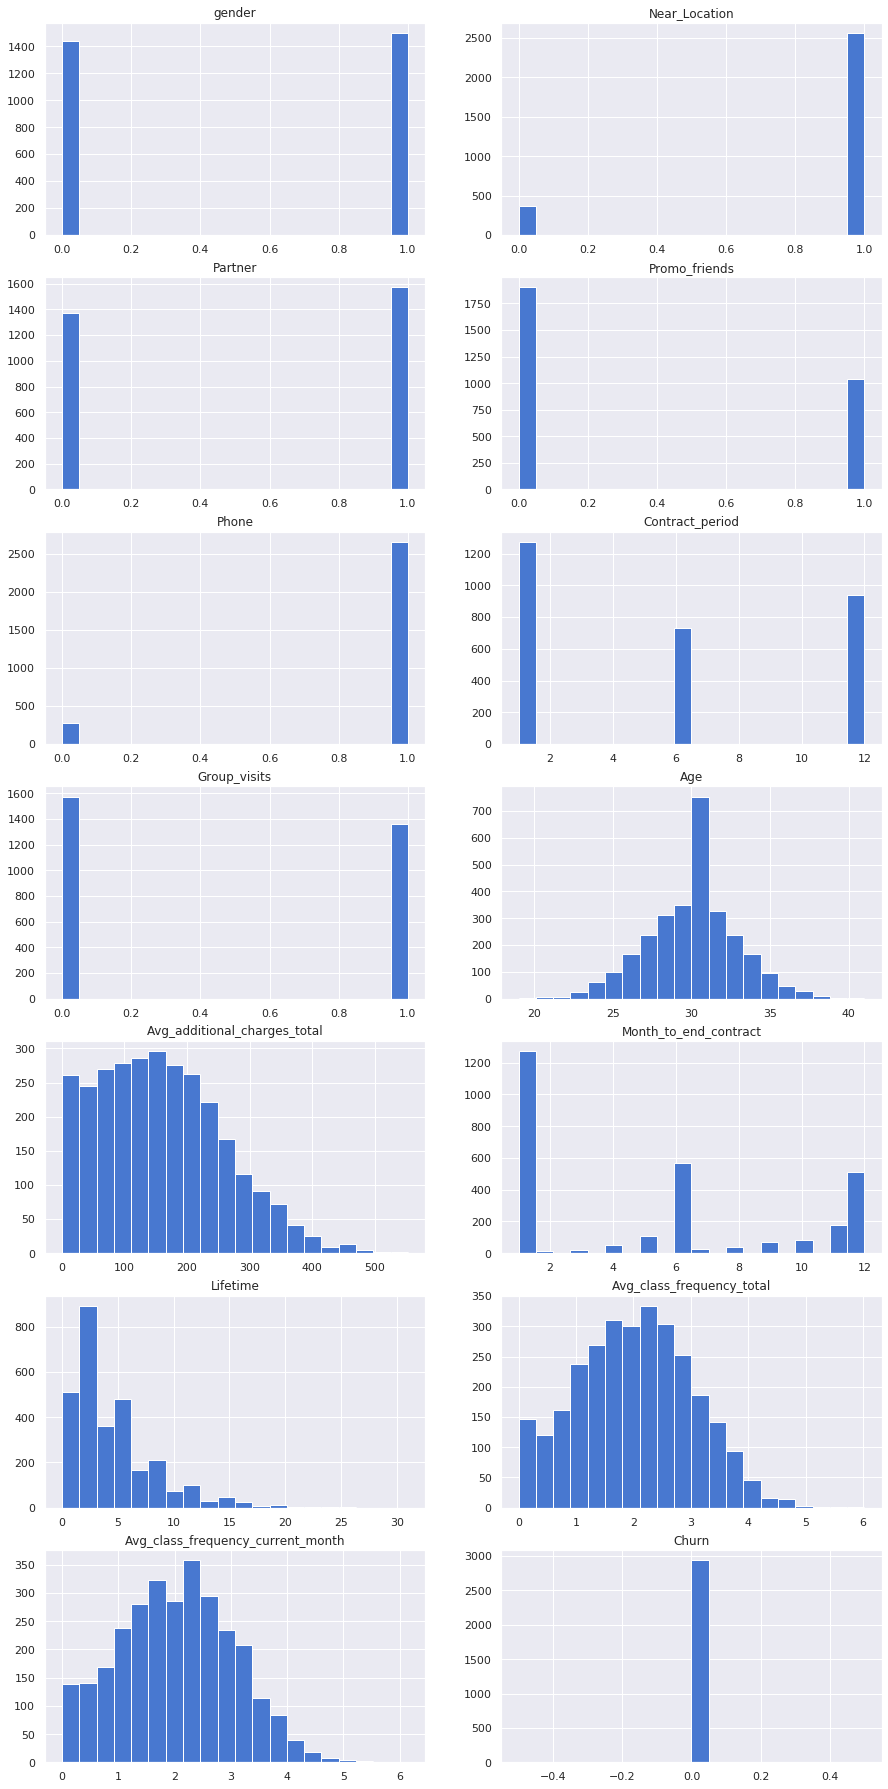

In [11]:
# для тех, кто остался

fig1, axs = plt.subplots(7, 2, figsize = (15,32))
a = 0
b = 0
for name in gym_not_lost.columns:
    axs[a, b].hist(gym_not_lost[name], bins = 20)
    axs[a, b].set_title(name)
    
    if b == 0:
        b = 1
    else:
        a += 1
        b = 0

Для тех, кто **остался** чаще характерно:

- проживание или работа в районе, где находится фитнес-центр (Near_Location);


- являлись сотрудником компании-партнёра клуба (Partner);


- отсутствие факта первоначальной записи в рамках акции «приведи друга» (Promo_friends);


- оставляли номер телефона (Phone);


- длительность текущего действующего абонемента (Contract_period) - `1 месяц`;


- присутствует факт посещения групповых занятий (Group_visits) (разница не так значительна: кто-то посещал, а кто-то - нет);


- средний возрас (Age) - `27-31 лет`;


- принесли среднюю суммарную выручку от других услуг фитнес-центра (Avg_additional_charges_total) - `до 250`;


- срок до окончания текущего действующего абонемента (Month_to_end_contract) - `1 месяц`;


- время с момента первого обращения в фитнес-центр (Lifetime) - `до 5 месяцев`;


- средняя частота посещений в неделю за все время с начала действия абонемента (Avg_class_frequency_total) - `2-3 раза` в неделю;


- средняя частота посещений в неделю за предыдущий месяц (Avg_class_frequency_current_month) - `2-3 раза` в неделю.

### Корреляция признаков

- Расчитаем корреляции для интервальных/ранговых и номинальных признаков по отдельности;


- Построим матрицы корреляции для тех, кто попал в отток и кто остался.

Определим степень зависимости признаков по шкале Чеддока:

<html>
 <head>
  <meta charset="utf-8">
 </head>
 <body>
  <table border="1", align="left">
   <tr>
    <th>Значение</th>
    <th>Связь</th>
   </tr>
   <tr>
    <td>0.1 - 0.3</td>
    <td>Слабая</td>
   </tr>   
   <tr>
    <td>0.3 - 0.5</td>
    <td>Умеренная</td>
    </tr>
    <tr>
    <td>0.5 - 0.7</td>
    <td>Заметная</td>
    </tr>
    <tr>
    <td>0.7 - 0.9</td>
    <td>Высокая</td>
    </tr>
    <tr>
    <td>0.9 - 0,99</td>
    <td>Весьма высокая</td>
  </tr>
 </table>
 </body>
</html>

`Разделим столбцы по типам шкал`, к которым относятся переменные:

- интервальные и ранговые признаки (`numerical`);

- номинальные признаки (`nominal`).



In [12]:
numerical = [
                'Age', 'Avg_additional_charges_total', 
                 'Month_to_end_contract', 'Lifetime', 'Contract_period',
                 'Avg_class_frequency_total', 'Avg_class_frequency_current_month'
            ]

nominal = [
                'gender', 'Near_Location', 'Partner', 
                'Promo_friends', 'Phone', 
                'Group_visits', 'Churn'
            ]

`Разобьем таблицы` тех, кто попал в отток и кто остался, по типам шкал для вычисления коэффициентов корреляции.

In [13]:
gym_lost_nominal = gym_lost.drop(numerical, axis = 1).drop('Churn', axis = 1) #отток - номинальные
gym_lost_numerical = gym_lost.drop(nominal, axis = 1) #отток - интервальные и ранговые

gym_not_lost_nominal = gym_not_lost.drop(numerical, axis = 1).drop('Churn', axis = 1) # остались - номинальные
gym_not_lost_numerical = gym_not_lost.drop(nominal, axis = 1) #остались - интервальные и ранговые

Найдем `коэффициенты V Крамера для номинальных` признаков.

Напишем `функцию`, которая будет:

- расчитывать коэффициент для каждой позиции на пересечении столбцов;


- создавать датафрейм для дальнейшей визуализации.

In [14]:
def cramers_table(dataframe):
    
    #функция для расчета коэффициента Крамера
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x,y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2/n
        r,k = confusion_matrix.shape
        phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
        rcorr = r-((r-1)**2)/(n-1)
        kcorr = k-((k-1)**2)/(n-1)
        return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
    
    #перебираем каждый столбец и соседствующий с ним для расчета коэффициента корреляции
    data = []
    for name in dataframe.columns:
        p = []
        for next_name in dataframe.columns:
            value = cramers_v(dataframe[name], dataframe[next_name])
            p.append(value)
        data.append(p)
    
    #возвращаем датафрейм с коэффициентами корреляции номинальных признаков
    return pd.DataFrame(data = data, columns = dataframe.columns, index = dataframe.columns)

`Применим функцию `для gym_not_lost_nominal (остались) и gym_lost_nominal (ушли в отток)

In [15]:
cramers_table(gym_not_lost_nominal)

,gender,Near_Location,Partner,Promo_friends,Phone,Group_visits
gender,0.999319,0.000000,0.000000,0.000000,0.000000,0.000000
Near_Location,0.000000,0.998464,0.000000,0.196654,0.000000,0.145634
Partner,0.000000,0.000000,0.999316,0.454098,0.007889,0.000000
Promo_friends,0.000000,0.196654,0.454098,0.999255,0.000000,0.097177
Phone,0.000000,0.000000,0.007889,0.000000,0.998044,0.000000
Group_visits,0.000000,0.145634,0.000000,0.097177,0.000000,0.999316


In [16]:
cramers_table(gym_lost_nominal)

,gender,Near_Location,Partner,Promo_friends,Phone,Group_visits
gender,0.998112,0.000000,0.000000,0.000000,0.000000,0.000000
Near_Location,0.000000,0.997351,0.035701,0.192041,0.000000,0.104351
Partner,0.000000,0.035701,0.997941,0.376247,0.000000,0.000000
Promo_friends,0.000000,0.192041,0.376247,0.996856,0.000000,0.065186
Phone,0.000000,0.000000,0.000000,0.000000,0.994619,0.028501
Group_visits,0.000000,0.104351,0.000000,0.065186,0.028501,0.997599


### Матрицы корреляции признаков

`Визуализируем наши данные`, чтобы нагляднее увидеть взаимосвязи признаков.

Для интервальных и ранговых признаков используем `метод Спирмена`.

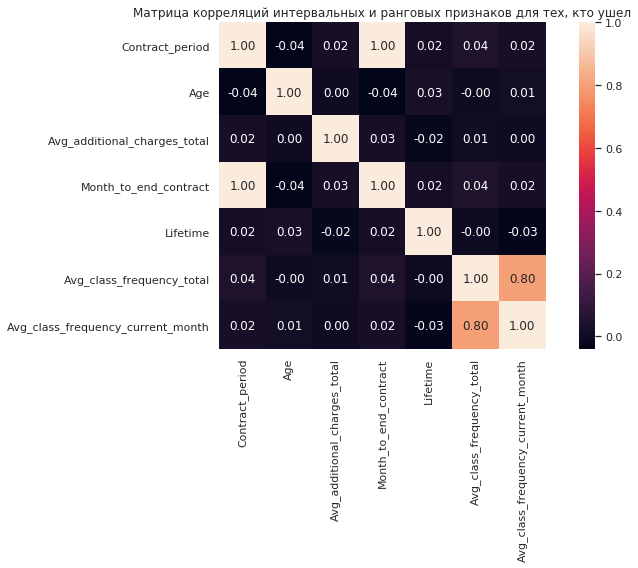

In [17]:
#корреляция интервальных и ранговых признаков
#для тех, кто ушел в отток

plt.figure(figsize = (12,6))
sns.heatmap(gym_lost_numerical.corr(method = 'spearman'), annot = True, fmt = '.2f',  square=True)

plt.title('Матрица корреляций интервальных и ранговых признаков для тех, кто ушел')
plt.show()

Между признаками у тех, кто ушел в отток, наблюдаются:

**Весьма высокая зависимость** между `Contract_period` (длительностью текущего действующего абонемента) и `Month_to_end_contract` (сроком до окончания текущего действующего абонемента) - `1`. 

Эта зависимость логична и ожидаема.

**Высокая зависимость** между `Avg_class_frequency_total` (средней частотой посещений в неделю за все время с начала действия абонемента) и `Avg_class_frequency_current_month` (средняя частота посещений в неделю за предыдущий месяц) - `0.8`. 

Исходя из условий и ритма жизни, клиенты фитнес-клуба стабильно придерживались удобного для себя режима посещений.

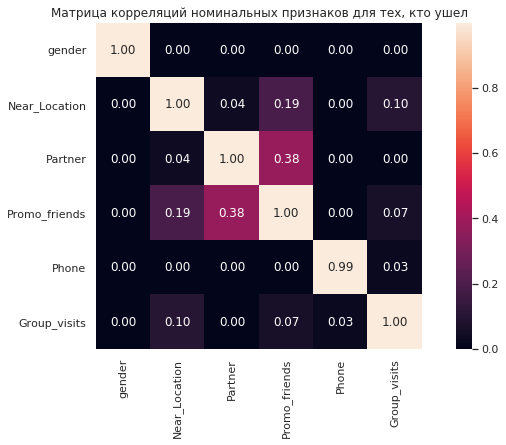

In [18]:
#корреляция номинальных признаков
#для тех, кто ушел в отток

plt.figure(figsize = (12,6))
sns.heatmap(cramers_table(gym_lost_nominal), annot = True, fmt = '.2f',  square=True)

plt.title('Матрица корреляций номинальных признаков для тех, кто ушел')
plt.show()

**Умеренная** связь между `Promo_friends` (фактом первоначальной записи в рамках акции «приведи друга») и `Partner` (сотрудник компании-партнёра клуба) - `0.38`.

Сотрудников компании-партнёра клуба обычно приводили коллеги, знакомые или друзья.

**Слабая** связь наблюдаются между `Near_Location и Promo_friends` - `0.19`.

Кто-то мог работать вблизи фитнес-клуба и, вполне вероятно, он привел своего коллегу, который записался в рамках акции «приведи друга».

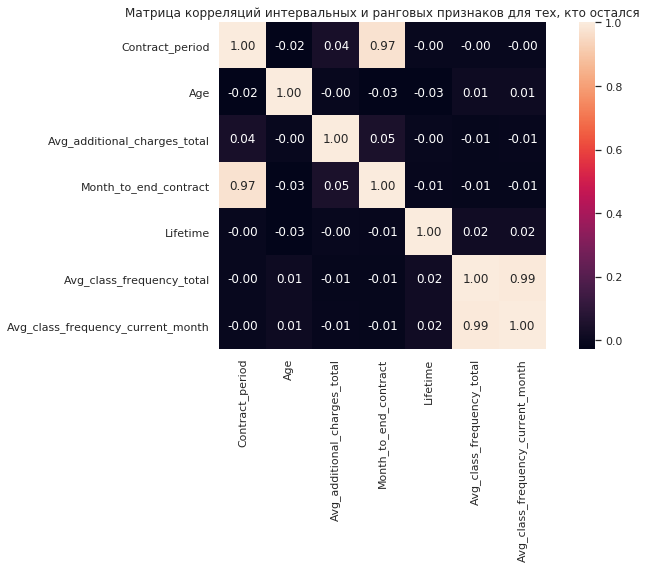

In [19]:
#корреляция интервальных и ранговых признаков
# для тех, кто остался

plt.figure(figsize = (12,6))
sns.heatmap(gym_not_lost_numerical.corr(method = 'spearman'), annot = True, fmt = '.2f',  square=True)

plt.title('Матрица корреляций интервальных и ранговых признаков для тех, кто остался')
plt.show()

Между признаками у тех, кто остался, можно увидеть:

**Весьма высокую зависимость** между:

- `Avg_class_frequency_total` (средней частотой посещений в неделю за все время с начала действия абонемента) и `Avg_class_frequency_current_month` (средняя частота посещений в неделю за предыдущий месяц) - `0.99`. 

Исходя из условий и ритма жизни, клиенты фитнес-клуба стабильно придерживаются удобного для себя режима посещений.

- `Contract_period` (длительностью текущего действующего абонемента) и `Month_to_end_contract` (сроком до окончания текущего действующего абонемента) - `0.97`. 

Эта зависимость логична и ожидаема.

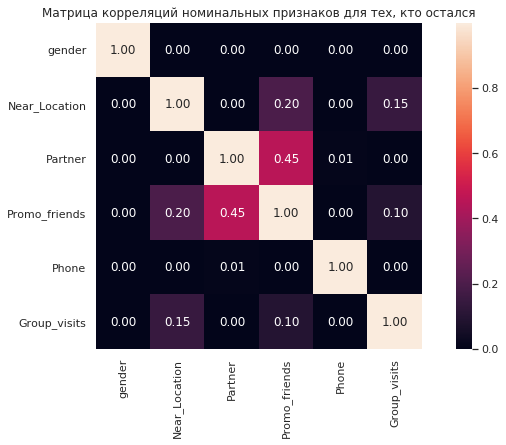

In [20]:
#корреляция номинальных признаков
#для тех, кто ушел в отток

plt.figure(figsize = (12,6))
sns.heatmap(cramers_table(gym_not_lost_nominal), annot = True, fmt = '.2f',  square=True)

plt.title('Матрица корреляций номинальных признаков для тех, кто остался')
plt.show()

**Умеренная** связь между `Promo_friends` (фактом первоначальной записи в рамках акции «приведи друга») и `Partner` (сотрудник компании-партнёра клуба) - `0.46`.

Сотрудников компании-партнёра клуба обычно приводят коллеги, знакомые или друзья.

**Слабые** связи наблюдаются между:

- `Near_Location и Promo_friends` - `0.2`.

Кто-то может работать недалеко от фитнес-клуба и, вполне вероятно, он привел своего коллегу, который записался в рамках акции «приведи друга».

- `Near_Location и Group_visits` - `0.15`.

Кто-то из клиентов, мог посещать групповые занятия с коллегами или знакомыми (если живет или работает недалеко от фитнес-клуба).

Проанализируем **взаимосвязь  признаков с целевой переменной** (Churn).

In [21]:
round(gym_churn.corr(method = 'spearman')['Churn'], 2).sort_values().reset_index()

,index,Churn
0,Lifetime,-0.58
1,Avg_class_frequency_current_month,-0.42
2,Contract_period,-0.40
3,Age,-0.40
4,Month_to_end_contract,-0.40
5,Avg_class_frequency_total,-0.25
6,Avg_additional_charges_total,-0.19
7,Group_visits,-0.18
8,Partner,-0.16
9,Promo_friends,-0.16


Коэффициенты корреляции - отрицательные, значит мы наблюдаем `обратные взаимосвязи`.

**Заметная взаимосвязь** между целевой переменной и `Lifetime` (время, с момента первого посещения фитнес-клуба) - `-0.58`.

Чем дольше клиент посещает фитнес-клуб, тем ниже шанс, что клиент попадет в отток.

**Умеренные корреляции** между целевой переменной и:

- частотой посещений в неделю за предыдущий месяц (`Avg_class_frequency_current_month`) (-0.42).

Чем чаще клиент посещал фитнес-клуб за предыдущий месяц, тем ниже вероятность его попадения в отток.

- длительностью текущего действующего абонемента (`Contract_period`) (-0.4).

Если клиент приобрел абонемент больше, чем на 1 месяц, то вероятность его попадения в отток снижается.

- возрастом клиентов (`Age`) (-0.4).

Чем старше клиент, тем ниже вероятность, что он уйдет.

- сроком до окончания текущего действующего абонемента (`Month_to_end_contract`) (-0.4).

Если срок до окончания абонемента больше, чем 1 месяц, то вероятность, что клиент уйдет ниже.

### Вывод

Проведя исследовательский анализ данных, были определены **средние значения признаков** для тех клинтов, кто попал в отток и кто остался.

`Средняя длительность текущего действующего абонемента` (Contract_period) у тех, кто:

- остался - 1 месяц, но `чаще покупают абонементы на 6 и 12 месяцев`;

- ушел - 1 месяц, почти не покупают абонементы на 6 и 12 месяцев.



`Средний возраст клиентов фитнес-клуба` (Age) у тех, кто:

- остался - 27 - 31 год;

- ушел - 26 - 29 лет.



`Средняя суммарная выручка от других услуг` фитнес-центра (Avg_additional_charges_total) у тех, кто:

- остался - до 250;

- ушел - до 120.


`Средний срок до окончания текущего действующего абонемента` (Month_to_end_contract) у тех, кто:

- остался - 1 месяц (встречаются и другие значения: следующие по рейтингу 6 и 12 месяцев);

- ушел - 1 месяц (другие значения почти не встречаются).


`Среднее время с момента первого обращения` в фитнес-центр (Lifetime) у тех, кто:

- остался - до 5 месяцев;

- ушел - до 1 месяца.


`Средняя частота посещений в неделю за все время` с начала действия абонемента (Avg_class_frequency_total) у тех, кто:

- остался - 2-3 раза в неделю;

- ушел - 1 раз в неделю.


`Средняя частота посещений в неделю за предыдущий месяц` (Avg_class_frequency_current_month) у тех, кто:

- остался - 2-3 раза в неделю;

- ушел - 0-1 раз в неделю.


Особых **корреляций между признаками** выявлено не было. 

В обеих группах наблюдаются ***высокие зависимости*** между `Avg_class_frequency_total` (средней частотой посещений в неделю за все время с начала действия абонемента) и `Avg_class_frequency_current_month` (средняя частота посещений в неделю за предыдущий месяц).

Это может говорить о том, что исходя из условий и ритма жизни, клиенты фитнес-клуба стабильно придерживались удобного для себя режима посещений (2-3 раза в неделю или всего один раз - как позволяло время).

***Умеренные связи*** между `Promo_friends` (фактом первоначальной записи в рамках акции «приведи друга») и `Partner` (сотрудник компании-партнёра клуба).

Можно сказать, что сотрудников компании-партнёра клуба обычно приводили коллеги, знакомые или друзья. Также можно отметить, что сотрудники компании-партнера получали скидки на абонементы. Это предложение изачально заинтересовало клиентов в обеих группах.

Также есть и ***слабые связи*** между `Near_Location` (проживание или работа в районе, где находится фитнес-центр) и `Promo_friends` (факт первоначальной записи в рамках акции «приведи друга»).

Кто-то мог работать вблизи фитнес-клуба и, вполне вероятно, он привел своего коллегу, который записался в рамках акции «приведи друга».

Были проанализированы **взаимосвязи признаков с целевой переменной** (Churn).

Коэффициенты корреляции - отрицательные, значит мы наблюдаем `обратные взаимосвязи`.

***Заметная взаимосвязь*** между целевой переменной и `Lifetime` (время, с момента первого посещения фитнес-клуба) (-0.58).

Чем дольше клиент посещает фитнес-клуб, тем ниже шанс, что клиент попадет в отток.

***Умеренные корреляции*** между целевой переменной и:

- частотой посещений в неделю за предыдущий месяц (`Avg_class_frequency_current_month`) (-0.42).

Чем чаще клиент посещал фитнес-клуб за предыдущий месяц, тем ниже вероятность его попадения в отток.

- длительностью текущего действующего абонемента (`Contract_period`) (-0.4).

Если клиент приобрел абонемент больше, чем на 1 месяц, то вероятность его попадения в отток снижается.

- возрастом клиентов (`Age`) (-0.4).

Чем старше клиент, тем ниже вероятность, что он уйдет.

- сроком до окончания текущего действующего абонемента (`Month_to_end_contract`) (-0.4).

Если срок до окончания абонемента больше, чем 1 месяц, то вероятность, что клиент уйдет ниже.

## Модель прогнозирования оттока клиентов

- Разбьем данные на обучающую и валидационную выборки функцией `train_test_split()`.


- Обучим модель на train-выборке двумя способами: `логистической регрессией` и `случайным лесом`.


- Оценим метрики `accuracy, precision и recall` для обеих моделей на валидационной выборке.

Сохраним датафрейм с учётом преобразования признаков в переменной `gym`.

In [22]:
gym = pd.get_dummies(gym_churn)

gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Разделим наши данные на признаки (`матрица X`) и `целевую переменную` (y).

Целевой переменной является факт оттока клиента (`Churn`)

In [23]:
X = gym.drop('Churn', axis = 1)
y = gym['Churn'] 

In [24]:
#разделим модель на обучающую и валидационную выборки.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123, stratify = y) 

#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

Зададим `список моделей`.

In [25]:
models = [
    LogisticRegression(random_state = 123, solver='liblinear'),
    RandomForestClassifier(n_estimators = 100, random_state = 123)
]

Напишем функцию `make_prediction`, которая будет:

- принимать на вход модель из списка и данные;


- `обучать` модель и `строить прогноз` на валидационной выборке;


- выводить метрики `Accuracy` (доля правильных ответов), `Precision` (точность) и `Recall` (полнота).

In [26]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f}'.format(
            accuracy_score(y_test, y_pred, ),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred)
        )
    )


#цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy:0.92 Precision:0.89 Recall:0.81
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
Accuracy:0.92 Precision:0.87 Recall:0.81


### Вывод

`Логистическая регрессия` (LogisticRegression) показала метрики `немного лучше`, чем Случайный лес (RandomForestClassifier).

LogisticRegression:

- Accuracy : 0.92
- Precision : 0.89
- Recall : 0.81

RandomForestClassifier:

- Accuracy : 0.92
- Precision : 0.87
- Recall : 0.81

## Кластеризация клиентов



`Стандартизируем данные`.

In [27]:
# обучаем нормализатор и преобразуем набор данных

x_sc = scaler.fit_transform(gym_churn.drop(columns = ['Churn'])) 

Построим матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков и `нарисуем дендрограмму`. 

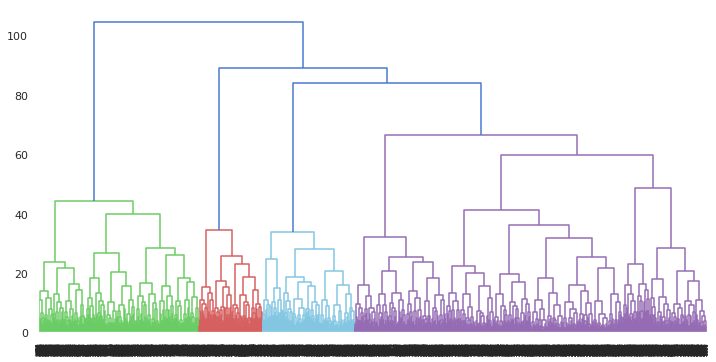

In [28]:
linked = linkage(x_sc, method = 'ward')

plt.figure(figsize=(12, 6))  
dendrogram(linked, orientation='top')
plt.show() 

Дендрограмма выделила 4 кластера, последний из которых значительно объемнее, чем предыдущие.

`Обучим модель кластеризации` на основании алгоритма `K-Means` и `спрогнозируем кластеры` клиентов. 

Укажем число кластеров `5`.

In [29]:
km = KMeans(n_clusters = 5, random_state = 123)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

Посмотрим на **средние значения признаков** для кластеров.



In [30]:
gym_churn.groupby('cluster_km').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.561850,0.848555,0.282081,0.073988,1.0,2.676301,0.448555,30.047399,161.300223,2.476301,4.858960,2.803888,2.796237,0.079769
1,0.493569,0.948553,0.813505,0.998392,1.0,3.020900,0.437299,29.051447,141.358831,2.829582,3.697749,1.701337,1.593120,0.262058
2,0.500577,0.936563,0.740484,0.480969,1.0,11.833910,0.547866,29.891580,163.330735,10.791234,4.713956,2.001043,1.993460,0.021915
3,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
4,0.485714,0.723810,0.296032,0.011111,1.0,1.926190,0.276984,28.135714,129.407081,1.832540,2.212698,1.255440,1.003779,0.561111


Можно заметить, что выделяется `2 кластер` со средним значением в `Contract_period` (длительность текущего действующего абонемента) - `11.83`. Люди из этой группы чаще покупают абонемент на 12 месяцев.

Рассмотрим распеределения подробнее.

Для наглядности разделим таблицу на `интервальные и номинальные признаки`, как делали ранее.

In [31]:
gym_numerical = gym_churn.drop(nominal, axis = 1) # таблица с числовыми признаками

gym_nominal = gym_churn.drop(numerical, axis = 1) # таблица с номинальными признаками

Построим **столбчатые диаграммы** распределения `номинальных признаков`.

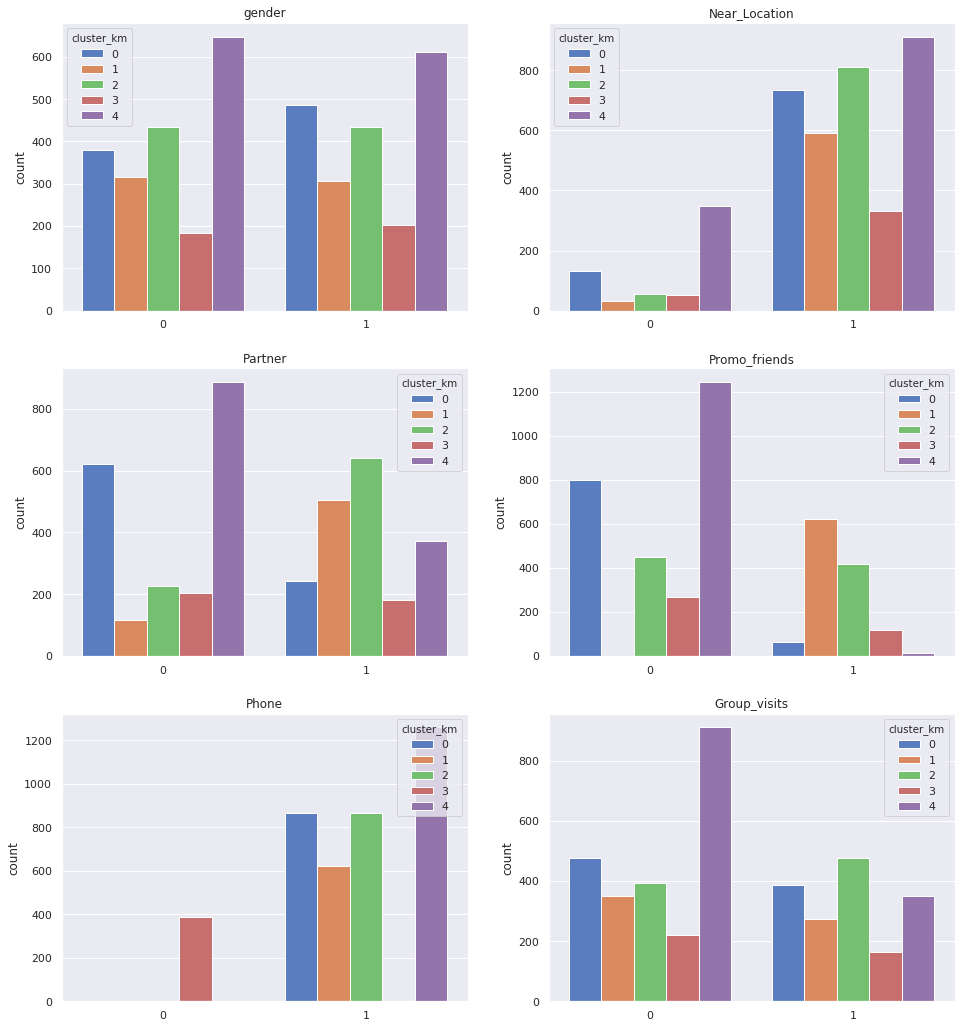

In [32]:
fig2, axs = plt.subplots(3, 2, figsize = (16,18))
a = 0
b = 0
#на долю оттока клиентов (Churn) мы посмотрим позже
for col in gym_nominal.drop(['Churn','cluster_km'], axis = 1).columns:
    sns.catplot(ax = axs[a, b], x=col, kind="count", data=gym_nominal, hue = 'cluster_km')
    axs[a, b].set_title(col)
    axs[a, b].set_xlabel("")
    if b == 0:
         b = 1
    else:
        a += 1
        b = 0
        
#catplot строит лишние сетки для графиков - удалим их
for i in range(2,10):
    plt.close(i)

***Характерные признаки для кластеров клиентов***.

Для `0 кластера` чаще всего наблюдается:

- проживают или работают в районе, где находится фитнес-центр;
- 2/3 клиентов не являются сотрудниками компании-партнёра клуба;
- пришли без программы "приведи друга";
- оставляли номер телефона для связи;
- больше половины клиентов не посещали групповые занятия;

Для `1 кластера` чаще всего наблюдается:
- проживают или работают в районе, где находится фитнес-центр;
- около 3/4 клиентов являются сотрудниками компании-партнёра клуба;
- пришли в рамках программы "приведи друга";
- оставляли номер телефона для связи;
- больше половины клиентов не посещали групповые занятия;

Для `2 кластера` чаще всего наблюдается:
- проживают или работают в районе, где находится фитнес-центр;
- около 3/4 клиентов являются сотрудниками компании-партнёра клуба;
- больше половины клиентов пришли без программы "приведи друга";
- оставляли номер телефона для связи;
- больше половины клиентов посещали групповые занятия;

Для `3 кластера` чаще всего наблюдаются:
- проживают или работают в районе, где находится фитнес-центр;
- больше половины клиентов не являются сотрудниками компании-партнёра клуба;
- около 2/3 клиентов пришли без акции "приведи друга";
- не оставляли номер телефона для связи;
- больше половины клиентов не посещали групповые занятия;

Для `4 кластера` чаще всего наблюдается:
- около 2/3 клиентов проживают или работают в районе, где находится фитнес-центр;
- 2/3 клиентов не являются сотрудниками компании-партнёра клуба;
- пришли без программы "приведи друга";
- оставляли номер телефона для связи;
- 2/3 клиентов не посещали групповые занятия.


Построим **"ящики с усами"**, чтобы отразить распределения `интервальных признаков`.

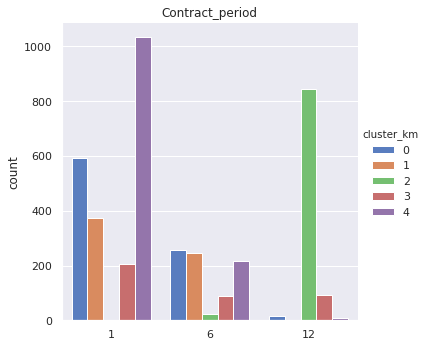

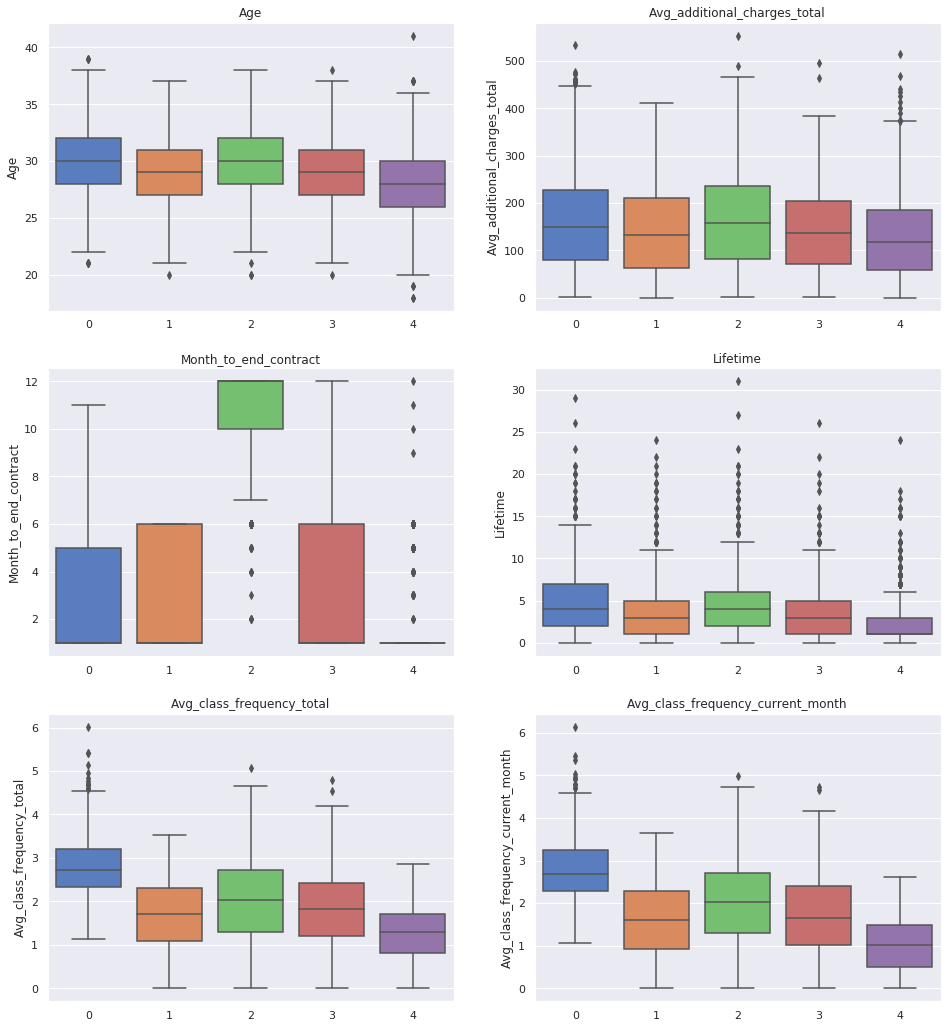

In [33]:
# столбчатая диаграмма для рангового столбца с длительностью абонемента
sns.catplot(x= 'Contract_period', kind="count", data=gym_numerical, hue = 'cluster_km')
plt.title('Contract_period')
plt.xlabel("")

# "ящики с усами" распределения интервальных признаков.
fig4, axs = plt.subplots(3, 2, figsize = (16,18))
a = 0
b = 0
for col in gym_numerical.drop(['Contract_period', 'cluster_km'], axis = 1).columns:
    sns.boxplot(ax = axs[a, b], x ='cluster_km',y = col, data = gym_numerical)
    axs[a, b].set_title(col)
    axs[a, b].set_xlabel("")
    if b == 0:
         b = 1
    else:
        a += 1
        b = 0

***Характерные признаки для кластеров клиентов***.

Для `0 кластера` чаще всего наблюдается:

- 2/3 клиентов приобретают абонемент на 1 месяц;
- средний возраст 28 - 33 года;
- средняя выручка от других услуг фитнес-клуба - до 250;
- до окончания действующего абонемента - обычно 1 месяц. Реже - 6 месяцев;
- время с момента первого обращения в фитнес-центр обычно до 5 месяцев;
- средняя частота посещений в неделю за все время с начала действия абонемента - 2-3 раза;
- средняя частота посещений в неделю за предыдущий месяц - 2-3 раза.

Для `1 кластера` чаще всего наблюдается:

- больше половины клиентов приобретают абонемент на 1 месяц;
- средний возраст 27 - 32 года;
- средняя выручка от других услуг фитнес-клуба - до 200;
- до окончания действующего абонемента - обычно 1 месяц. Реже - 6 месяцев;
- время с момента первого обращения в фитнес-центр обычно до 3 месяцев;
- средняя частота посещений в неделю за все время с начала действия абонемента - 1-2 раза;
- средняя частота посещений в неделю за предыдущий месяц - 1-2 раза.

Для `2 кластера` чаще всего наблюдается:

- почти 80% клиентов приобретают абонемент на 12 месяцев;
- средний возраст клиентов - 28 - 33;
- средняя выручка от других услуг фитнес-клуба - до 250;
- до окончания действующего абонемента - 12 месяцев;
- время с момента первого обращения в фитнес-центр обычно до 5 месяцев;
- средняя частота посещений в неделю за все время с начала действия абонемента - 1-3 раза;
- средняя частота посещений в неделю за предыдущий месяц - 1-3 раза.

Для `3 кластера` чаще всего наблюдаются:

- половина клиентов приобретают абонемент на 1 месяц;
- средний возраст 27 - 32 года;
- средняя выручка от других услуг фитнес-клуба - до 200;
- до окончания действующего абонемента - обычно 1 месяц;
- время с момента первого обращения в фитнес-центр обычно до 3 месяцев;
- средняя частота посещений в неделю за все время с начала действия абонемента - 1-2 раза;
- средняя частота посещений в неделю за предыдущий месяц - 1-2 раза.

Для `4 кластера` чаще всего наблюдается:

- 80% клиентов приобретают абонемент на 1 месяц. На 12 месяцев обычно не покупают;
- большая часть клиентов - около 25 лет (26 - 30);
- средняя выручка от других услуг фитнес-клуба - до 200;
- до окончания действующего абонемента у 80% клиентов - 1 месяц;
- время с момента первого обращения в фитнес-центр обычно до 1 месяца;
- средняя частота посещений в неделю за все время с начала действия абонемента - 1-2 раза;
- средняя частота посещений в неделю за предыдущий месяц - 0-2 раза. Кто-то не приходил на неделе вовсе, кто-то посещал фитнес-клуб как обычно - 1-2 раза в неделю.

Для каждого полученного кластера **посчитаем долю оттока**.

In [34]:
gym_churn.groupby(['cluster_km', 'Churn'])['Churn'].count()

cluster_km  Churn
0           0        796
            1         69
1           0        459
            1        163
2           0        848
            1         19
3           0        283
            1        103
4           0        553
            1        707
Name: Churn, dtype: int64

Представим данные в виде `круговой диаграммы`.

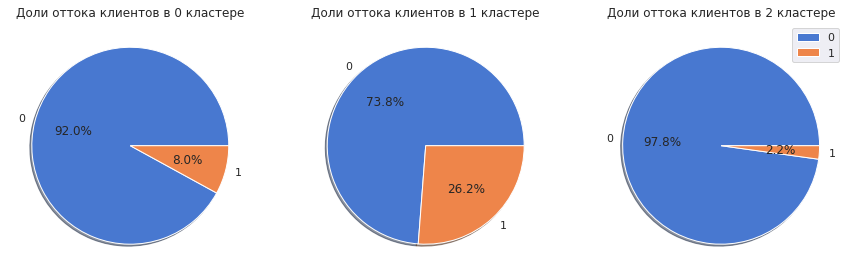

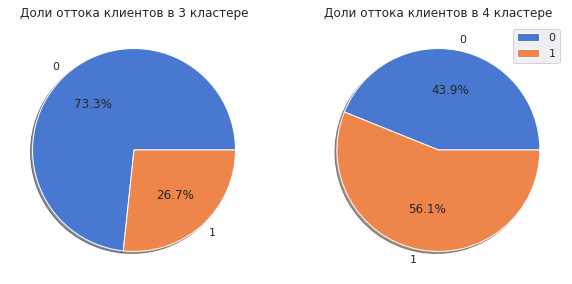

In [35]:
fig4 = plt.subplots(1, 3, figsize = (15,5))
m = 1
for i in range(3):
    group = gym_churn[gym_churn['cluster_km'] == i].groupby('Churn')['Churn'].count()
    
    plt.subplot(1,3, m)
    plt.pie(group, labels = group.index,  autopct='%1.1f%%', shadow=True)
    plt.title('Доли оттока клиентов в {} кластере'.format(i))
    m += 1
    
plt.legend()
plt.show()


fig5 = plt.subplots(1, 2, figsize = (10,5))
f = 1
for i in range(3,5):
    group = gym_churn[gym_churn['cluster_km'] == i].groupby('Churn')['Churn'].count()
    
    plt.subplot(1,2, f)
    plt.pie(group, labels = group.index,  autopct='%1.1f%%', shadow=True)
    plt.title('Доли оттока клиентов в {} кластере'.format(i))
    f += 1
    
plt.legend()
plt.show()

Кластеры отличаются по доле оттока.

`Надежными` можно назвать:

- `2` кластер (2.2% оттока);


- `0` кластер (8% оттока).


`Менее надежные` кластеры:

- `1` кластер (26.2% оттока);


- `3` кластер (26.7% оттока).


`Необходимо работать с кластером`, доля оттока в котором составляет `более 50%`. Это `4` кластер (56.1% оттока).


### Вывод

Была проведена кластеризация клиентов фитнес-клуба. Были `выделены 5 кластеров` и характерные для них признаки.

**Надежными** можно назвать `2 кластер` (2.2% оттока) и `0 кластер` (8% оттока).

Для обоих кластеров характерно `проживание или работа в районе`, где находится фитнес-центр, и факт того, что большая часть из них `пришли без акции "приведи друга"`.

Эти клиенты `оставляли номер телефона` для связи и чаще не первый месяц посещают фитнес-центр: время с момента `первого обращения обычно до 5 месяцев`.

Клиенты обоих кластеров стабильно посещают фитнес-клуб: средняя `частота посещений в неделю за все время` с начала действия абонемента и за предыдущий месяц - `1-3 раза`. 

Клиенты из 0-ого кластера посещают немного чаще (`2-3 раза в неделю`).

Также эти кластеры приносят фитнес-клубу `большую среднюю выручку` от дополнительных услуг - до 250.

Для ***0 кластера*** чаще всего наблюдаются признаки:

- 2/3 клиентов `не являются сотрудниками` компании-партнёра клуба;


- больше половины клиентов `не посещали групповые занятия`;


- 2/3 клиентов приобретают `абонемент на 1 месяц`;


- средний возраст `28 - 32 года`;


- `до окончания` действующего `абонемента` - обычно `1 месяц`. Реже - 6 месяцев.


Для ***2 кластера*** чаще всего наблюдается:

- около 3/4 клиентов `являются сотрудниками` компании-партнёра клуба;


- больше половины клиентов `посещали групповые занятия`;


- почти 80% клиентов приобретают `абонемент на 12 месяцев`;


- средний возраст клиентов - `28 - 33`;


- `до окончания` действующего `абонемента` - `12 месяцев`.


**Менее надежные** кластеры - - `1 кластер` (26.2% оттока) и `3 кластер` (26.7% оттока).

Клиенты из этих кластеров `проживают или работаю в районе`, где находится фитнес-клуб. Их средний средний возраст - обычно 27-32 года.

Больше половины клиентов в каждом кластере `не посещали групповые занятия` и приобретают `абонемент` обычно `на 1 месяц`.

Клиенты этих кластеров обычно посещают фитнес-клуб 2ой месяц: время с момента `первого обращения` в фитнес-центр обычно `до 3 месяцев`. 

Они приносят компании `среднюю выручку от других услуг` фитнес-клуба меньше, чем "надежные" кластеры - до 200.

Тренируются клиенты стабильно `1-2 раза в неделю`.

Для ***1 кластера*** чаще всего наблюдается:

- около 3/4 клиентов `являются сотрудниками` компании-партнёра клуба;


- `пришли в рамках программы` "приведи друга";


- `оставляли номер` телефона для связи;


- `до окончания` действующего `абонемента` - обычно `1 месяц`. Реже - 6 месяцев.



Для ***3 кластера*** чаще всего характерны признаки:

- больше половины клиентов `не являются сотрудниками` компании-партнёра клуба;


- около 2/3 клиентов `пришли без акции "приведи друга"`;


- `не оставляли номер` телефона для связи;


- `до окончания` действующего `абонемента` - обычно `1 месяц`.




**Необходимо работать с кластером**, `доля оттока` в котором составляет `более 50%`. 

Это ***4 кластер*** (56.1% оттока). Для клиентов этой группы характерны признаки:

- около 2/3 клиентов `проживают или работают в районе`, где находится фитнес-центр;


- 2/3 клиентов `не являются сотрудниками` компании-партнёра клуба;


- `пришли без программы` "приведи друга";


- `оставляли номер` телефона для связи;


- 2/3 клиентов `не посещали групповые занятия`;


- 80% клиентов приобретают `абонемент на 1 месяц`. На 12 месяцев обычно не покупают;


- большая часть клиентов - `около 25 лет (26 - 30)`;


- средняя `выручка от других услуг` фитнес-клуба - до 200;


- `до окончания` действующего `абонемента` у 80% клиентов - `1 месяц`;


- время с момента `первого обращения` в фитнес-центр обычно `до 1 месяца`;


- средняя частота `посещений в неделю за все время` с начала действия абонемента - `1-2 раза`;


- средняя частота `посещений в неделю за предыдущий месяц` - `0-2 раза`. 

Кто-то не приходил на неделе вовсе, кто-то посещал фитнес-клуб как обычно - 1-2 раза в неделю.


## Рекомендации по работе с клиентами

В ходе кластеризации клиентов был определен **кластер, который чаще склонен к оттоку**. Это `4 кластер` (56.1% оттока).

Эти клиенты - обычно молодые люди `около 25 лет (25 - 30)`, которые `проживают или работают в районе`, где находится фитнес-центр. 

Они приходят впервые и приобретают `абонемент на 1 месяц`. Стабильно посещают зал `1-2 раза в неделю`, и их отток легко отследить - они `начинают посещать фитнес-клуб реже`: большая доля из них приходит на неделе 1 раз, или не приходит вовсе.

Клиенты в этом кластере приходят обычно самостоятельно - `не в рамках акции "приведи друга"`. Велика вероятность, что первый месяц они посещаю финес-клуб в одиночестве (без коллег и знакомых). 

Также 2/3 клиентов `не посещали групповые занятия`, а значит большая часть этих клиентов не имела удобной возможности найти себе новых знакомых.

**Рекомендации по удержанию клиентов** направлены не только на работу с данным кластером клиентов, но и могут помочь улучшить качество сервиса и услуг фитнес-клуба.

1.***Вовлечение клиентов в улучшение качества сервиса/услуг***

Важно дать возможность клиенту участвовать в жизни компании. Он почувствует свою причастность - это стимулирует удержание. 

- Можно ненавязчиво задавать вопросы о качестве услуг, уровне сервиса и других нюансах.


- предложить `бонусы или скидки за заполнение анкеты` обратной связи.

2.***Скидки и акций на абомененты***

Возможность сэкономить или получить подарки – мощный стимул для покупателей. 

- Можно создать `акцию на покупку последующего абонемента` в течении 3 дней или недели с момента завершения предыдущего.

Скидки могут заинтересовать клиента и мотивировать его совершить покупку нового абонемента и, соответсвенно, продолжить посещать фитнес-клуб.

3.***Продвижение групповых занятий***

Большая часть клиентов из указанных кластеров не посещали групповые занятия. Стоит отметить, что первый месяц является наиболее уязвимым периодом жизни нового клиента в фитнес-клубе: у него формируются новые привычки, складываются взаимоотношения с персоналом и другими посетителями.

В рамках групповых занятий участники подпитываются энергией группы и получают удовольствие от поддержки и чувства сопричастности, которые им дают инструктор и другие участники.


- Можно предложить `бонусы или небольшие скидки` на другие услуги фитнес-клуба `за посещение группового занятия`.

Это может стать мотивацией, чтобы клиент посетил первое групповое занятие - вероятность, что ему понравится и он продолжит заниматься в группе, значительно выше, если он посетит хотя бы одно такое занятие.

К тому же, обретя новых знакомых в фитнес-клубе, шанс, что клиент покинет его снижается.
